In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, TimeSeriesOutcome, IntegerParameter, RealParameter)
#from dike_model_function import DikeNetwork  # @UnresolvedImport
#from dike_model_function_time_series import DikeNetworkTS  # @UnresolvedImport
from problem_formulation_V2_0 import get_model_for_actor_problem_formulation

#https://www.sciencedirect.com/science/article/pii/S1364815217311581
#paper of kwakkel on Sobol Sensitivity analysis

In [3]:
# Problem formulations:
#    get_model_for_actor_problem_formulation(problem_formulation_id, outcome_type='time_series')
#    problem_formulation_id options
#        1 - RWS (GOOD)
#        2 - Environmental interest group
#        3 - Transport company 
#        4 - Delta commission
#        5 - Gelderland (GOOD)
#        6 - Overijssel (GOOD)s
#        7 - Dike rings 1 and 2
#        8 - Dike ring 3
#        9 - Dike ring 4
#        10 - Dike ring 5
#
#    outcome_type options
#        'time_series' (default)
#        'scalar'


model, planning_steps = get_model_for_actor_problem_formulation(1, outcome_type='scalar')

In [ ]:
for i in model.levers:
    print(arg)

# Global SA over Uncertainties

In [7]:
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator, SequentialEvaluator)

from SALib.analyze import sobol

In [5]:
# Reproducing the uncertainties defined in the dike model
# It does not matter which problem formulation id is used here, since the uncertainties are the same in every PF

uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)

# Transferring the uncertainties to the desired SALib problem format
problem = get_SALib_problem(uncertainties)

In [4]:
#formulate levers as the centre of the sobol analysis
#We run a sensitivity analysis of the input space because we want to get an idea of the relative importance of the levers

levers = []
for lever in model.levers:
    levers.append(lever)

# Transferring the uncertainties to the desired SALib problem format
problem = get_SALib_problem(levers)

In [ ]:
#PROBLEMS WITH RUNNING THIS --> Key error on dikeIncrease 0 (phillip has the same how?)

n_input_samples = 1

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_input_samples,
                                                        uncertainty_sampling=SOBOL)

In [8]:
#when you run sobol with the sequential evaluator, you get the error

n_input_samples = 1

with SequentialEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_input_samples,
                                                        uncertainty_sampling=SOBOL)

'DikeIncrease 0'
Traceback (most recent call last):
  File "C:\Users\ivarnieuwepc\Anaconda3\lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 84, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\ivarnieuwepc\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\ivarnieuwepc\Anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 338, in run_model
    outputs = self.run_experiment(experiment)
  File "C:\Users\ivarnieuwepc\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\ivarnieuwepc\Anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 391, in run_experiment
    model_output = self.function(**experiment)
  File "C:\Users\ivarnieuwepc\Desktop\Master EPA\EPA1361 Model Based Decision Making\mbdm_1_RfR\Analysis - generate alternatives\Model\dike_model

EMAError: exception in run_model
Caused by: KeyError: 'DikeIncrease 0'

In [53]:
# Expected Annual Damage Sobol outcomes
EAD_final_sobol = outcomes_sobol['Expected Annual Damage']
EAD_score = sobol.analyze(problem, EAD_final_sobol, calc_second_order=True, print_to_console=False)

# Total Investment Costs Sobol outcomes
TIC_final_sobol = outcomes_sobol['Total Investment Costs']
TIC_score = sobol.analyze(problem, TIC_final_sobol, calc_second_order=True, print_to_console=False)

# Expected Number of Deaths Sobol outcomes
END_final_sobol = outcomes_sobol['Expected Number of Deaths']
END_score = sobol.analyze(problem, END_final_sobol, calc_second_order=True, print_to_console=False)

In [63]:
def plot_sobol_interaction(sobol_score):
    Si_filter = {k:sobol_score[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,12)
    fig.subplots_adjust(bottom=0.3)
    plt.title('Sobol Score')
    ax.set(xlabel='Levers', ylabel='Fraction of total variance')
    plt.show()

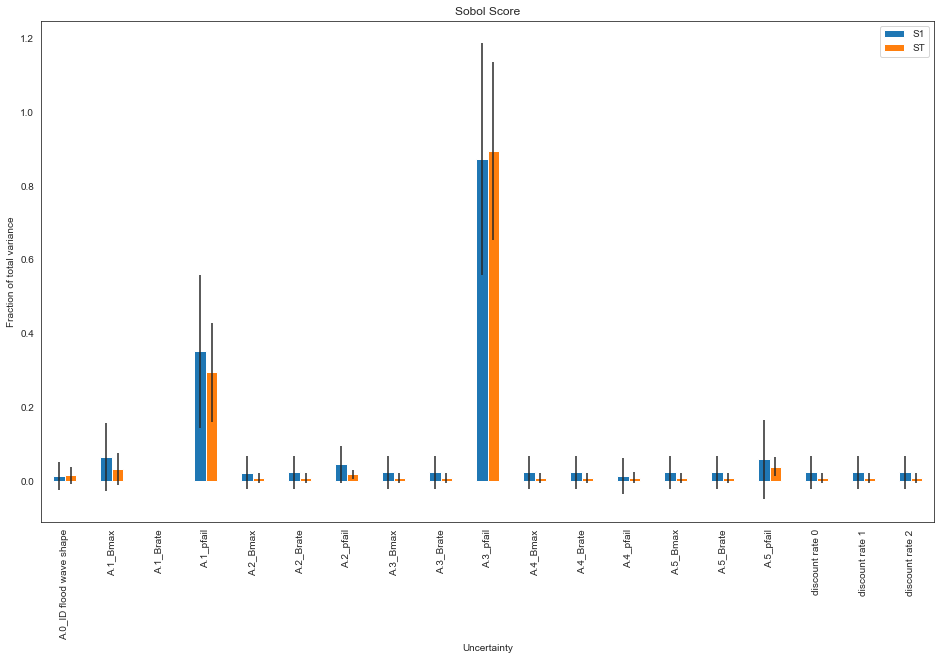

In [65]:
plot_sobol_interaction(END_score)

In [81]:
# We can also study the convergence of the Sobol indices as a function of the number of samples,
# by computing the indices over a partial sample:

# Y = EAD_final_sobol

def plot_sobol_convergence(final_sobol):

    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(2,n_exp,5)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, final_sobol[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
        
    fig, ax = plt.subplots(1)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Input samples')
    ax.set_ylabel('Total index (ST)')
    plt.show()

In [82]:
plot_sobol_convergence(EAD_final_sobol)

TypeError: __init__() got an unexpected keyword argument 'legend_out'